# Chen's data

In [39]:
import matplotlib.pyplot as plt

# Saving
import pickle

# Datetime
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
# import torchvision
# from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# sklearn
from sklearn.preprocessing import StandardScaler

# Other tools
import time
import os
import copy

# from VQC_GRAD_META_CONSTRUCT import load_JET_4_var_two

from metaquantum.CircuitComponents import *
from metaquantum import Optimization

# Qiskit
import qiskit
import qiskit.providers.aer.noise as noise

# Custom qiskit noise model
#from ibm_noise_models import thermal_noise_backend, combined_error_noisy_backend, combined_noise_backend_normdist


# Dataset
# from generate_lstm_dataset import get_sine_data
# from data.load_air_passengers import get_air_passenger_data_single_predict
# from data.damped_shm import get_damped_shm_data
from data.bessel_functions import get_bessel_data
# from data.delayed_quantum_control import get_delayed_quantum_control_data
# from data.population_inversion_revised import get_population_inversion_data
# from generate_lstm_dataset import get_sine_data_single_predict
# from data.narma_data_set import get_narma2_data
# from data.narma_generator import get_narma_data

##
# Device auto select
# dtype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
# device = 'cuda' if torch.cuda.is_available() else 'cpu'


from lstm_base_class import VQLSTM
from lstm_federated_data_prepare import TimeSeriesDataSet


## Training
def MSEcost(VQC, X, Y, h_0, c_0, seq_len):
	"""Cost (error) function to be minimized."""

	# predictions = torch.stack([variational_classifier(var_Q_circuit = var_Q_circuit, var_Q_bias = var_Q_bias, angles=item) for item in X])

	loss = nn.MSELoss()
	output = loss(torch.stack([VQC.forward(vec.reshape(seq_len,1), h_0, c_0).reshape(1,) for vec in X]), Y.reshape(Y.shape[0],1))
	print("LOSS AVG: ",output)
	return output

def train_epoch_full(opt, VQC, data, h_0, c_0, seq_len, batch_size):
	losses = []
	time_series_data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

	for X_train_batch, Y_train_batch in time_series_data_loader:

		since_batch = time.time()
		opt.zero_grad()
		print("CALCULATING LOSS...")
		loss = MSEcost(VQC = VQC, X = X_train_batch, Y = Y_train_batch, h_0 = h_0, c_0 = c_0, seq_len = seq_len)
		print("BACKWARD..")
		loss.backward()
		losses.append(loss.data.cpu().numpy())
		opt.step()
# 		print("LOSS IN CLOSURE: ", loss)
		print("FINISHED OPT.")
		print("Batch time: ", time.time() - since_batch)

	losses = np.array(losses)
	return losses.mean()


def saving(exp_name, exp_index, train_len, iteration_list, train_loss_list, test_loss_list, model, simulation_result, ground_truth):
	file_name = exp_name + "_NO_" + str(exp_index) + "_Epoch_" + str(iteration_list[-1])
	saved_simulation_truth = {
	"simulation_result" : simulation_result,
	"ground_truth" : ground_truth
	}

	if not os.path.exists(exp_name):
		os.makedirs(exp_name)

	# Save the train loss list
	with open(exp_name + "/" + file_name + "_TRAINING_LOST" + ".txt", "wb") as fp:
		pickle.dump(train_loss_list, fp)

	# Save the test loss list
	with open(exp_name + "/" + file_name + "_TESTING_LOST" + ".txt", "wb") as fp:
		pickle.dump(test_loss_list, fp)

	# Save the simulation result
	with open(exp_name + "/" + file_name + "_SIMULATION_RESULT" + ".txt", "wb") as fp:
		pickle.dump(saved_simulation_truth, fp)

	# Save the model parameters
	torch.save(model.state_dict(), exp_name + "/" +  file_name + "_torch_model.pth")

	# Plot
	plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list)
	plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth)

	return


def plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list):
	# Plot train and test loss
	fig, ax = plt.subplots()
	# plt.yscale('log')
	ax.plot(iteration_list, train_loss_list, '-b', label='Training Loss')
	ax.plot(iteration_list, test_loss_list, '-r', label='Testing Loss')
	leg = ax.legend();

	ax.set(xlabel='Epoch', 
		   title=exp_name)
	fig.savefig(exp_name + "/" + file_name + "_" + "loss" + "_"+ datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
	plt.clf()

	return

def plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth):
	# Plot the simulation
	plt.axvline(x=train_len, c='r', linestyle='--')
	plt.plot(simulation_result, '-')
	plt.plot(ground_truth.detach().numpy(), '--')
	plt.suptitle(exp_name)
	# savfig can only be placed BEFORE show()
	plt.savefig(exp_name + "/" + file_name + "_" + "simulation" + "_"+ datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
	return

#



def main():

	dtype = torch.DoubleTensor
	device = 'cpu'


	qdevice = "default.qubit" 
	# qdevice = "qulacs.simulator"

	# gpu_q = True
	gpu_q = False

	##
	duplicate_time_of_input = 1

	lstm_input_size = 1
	lstm_hidden_size = 3
	lstm_cell_cat_size = lstm_input_size + lstm_hidden_size
	lstm_internal_size = 4
	lstm_output_size = 4  
	lstm_cell_num_layers = 2 
	lstm_num_qubit = 4

	as_reservoir = False

	use_qiskit_noise_model = False


	dev = None

	if use_qiskit_noise_model:
		noise_model = combined_noise_backend_normdist(num_qubits = lstm_num_qubit)
		dev = qml.device('qiskit.aer', wires=lstm_num_qubit, noise_model=noise_model)

	else:
		dev = qml.device("default.qubit", wires = lstm_num_qubit)


	# Initialize the model
	model = VQLSTM(lstm_input_size = lstm_input_size, 
		lstm_hidden_size = lstm_hidden_size,
		lstm_output_size = lstm_output_size,
		lstm_num_qubit = lstm_num_qubit,
		lstm_cell_cat_size = lstm_cell_cat_size,
		lstm_cell_num_layers = lstm_cell_num_layers,
		lstm_internal_size = lstm_internal_size,
		duplicate_time_of_input = duplicate_time_of_input,
		as_reservoir = as_reservoir,
		single_y = True,
		output_all_h = False,
		qdevice = qdevice,
		dev = dev,
		gpu_q = gpu_q).double()

	# Load the data

	x, y = get_bessel_data()

	num_for_train_set = int(0.67 * len(x))

	x_train = x[:num_for_train_set].type(dtype)
	y_train = y[:num_for_train_set].type(dtype)

	train_data = TimeSeriesDataSet(x_train, y_train)

	x_test = x[num_for_train_set:].type(dtype)
	y_test = y[num_for_train_set:].type(dtype)

	test_data = TimeSeriesDataSet(x_test, y_test)

	print("x_train: ", x_train)
	print("x_test: ", x_test)


	h_0 = torch.zeros(lstm_hidden_size,).type(dtype)
	c_0 = torch.zeros(lstm_internal_size,).type(dtype)

	print("First data: ", x_train[0])
	print("First target: ", y_train[0])
	# first_run_h, first_run_c = model.forward(x_train[0].reshape(4,1), h_0, c_0)
	first_run = model.forward(x_train[0].reshape(4,1), h_0, c_0)
	# print("Output of first_run_h: ", first_run_h)
	# print("Output of first_run_c: ", first_run_c)


	exp_name = "VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_{}_QUBIT".format(lstm_num_qubit)


	if as_reservoir:
		exp_name += "_AS_RESERVOIR"

	if use_qiskit_noise_model:
		exp_name += "_QISKIT_NOISE"


	exp_name += "_{}_QuLAYERS".format(lstm_cell_num_layers)

	exp_index = 2
	train_len = len(x_train)

	opt = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
	train_loss_for_all_epoch = []
	test_loss_for_all_epoch = []
	iteration_list = []
	for i in range(100):
        print(f'Epoch {i+1}')
		iteration_list.append(i + 1)
		c_0 = torch.zeros(lstm_internal_size,).type(dtype)
		h_0 = torch.zeros(lstm_hidden_size,).type(dtype)


		train_loss_epoch = train_epoch_full(opt = opt, VQC = model, data = train_data, h_0 = h_0, c_0 = c_0, seq_len = 4,batch_size = 10)
		print("c_0: ", c_0)
		print("h_0: ", h_0)
		test_loss = MSEcost(VQC = model, X = x_test, Y = y_test, h_0 = h_0, c_0 = c_0, seq_len = 4)
		print("TEST LOSS: ", test_loss)

		# train_loss_for_all_epoch.append(train_loss_epoch)
		# test_loss_for_all_epoch.append(test_loss)
		train_loss_for_all_epoch.append(train_loss_epoch.numpy())
		test_loss_for_all_epoch.append(test_loss.detach().numpy())

		plot_each_epoch = True
		if plot_each_epoch == True:
			total_res = None
			ground_truth_y = None
			if device == 'cuda':
				total_res = torch.stack([model.forward(vec.reshape(4,1), h_0, c_0).reshape(1,) for vec in x.type(dtype)]).detach().cpu().numpy()
				ground_truth_y = y.clone().detach().cpu()
			else:
				total_res = torch.stack([model.forward(vec.reshape(4,1), h_0, c_0).reshape(1,) for vec in x.type(dtype)]).detach().numpy()
				ground_truth_y = y.clone().detach()

			saving(
				exp_name = exp_name, 
				exp_index = exp_index, 
				train_len = train_len, 
				iteration_list = iteration_list, 
				train_loss_list = train_loss_for_all_epoch, 
				test_loss_list = test_loss_for_all_epoch, 
				model = model, 
				simulation_result = total_res, 
				ground_truth = ground_truth_y)

	return




if __name__ == '__main__':
	main()

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-39-78fe1147a77f>, line 262)

# Trying with our data

In [ ]:
import matplotlib.pyplot as plt

# Saving
import pickle

# Datetime
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
# import torchvision
# from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# pandas
import pandas as pd

# Other tools
import time
import os
import copy

# from VQC_GRAD_META_CONSTRUCT import load_JET_4_var_two

from metaquantum.CircuitComponents import *
from metaquantum import Optimization

# Qiskit
import qiskit
import qiskit.providers.aer.noise as noise

# Custom qiskit noise model
#from ibm_noise_models import thermal_noise_backend, combined_error_noisy_backend, combined_noise_backend_normdist


# Dataset
# from generate_lstm_dataset import get_sine_data
# from data.load_air_passengers import get_air_passenger_data_single_predict
# from data.damped_shm import get_damped_shm_data
from data.bessel_functions import get_bessel_data
# from data.delayed_quantum_control import get_delayed_quantum_control_data
# from data.population_inversion_revised import get_population_inversion_data
# from generate_lstm_dataset import get_sine_data_single_predict
# from data.narma_data_set import get_narma2_data
# from data.narma_generator import get_narma_data

##
# Device auto select
# dtype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
# device = 'cuda' if torch.cuda.is_available() else 'cpu'


from lstm_base_class import VQLSTM
from lstm_federated_data_prepare import TimeSeriesDataSet


## Training
def MSEcost(VQC, X, Y, h_0, c_0, seq_len):
	"""Cost (error) function to be minimized."""

	# predictions = torch.stack([variational_classifier(var_Q_circuit = var_Q_circuit, var_Q_bias = var_Q_bias, angles=item) for item in X])

	loss = nn.MSELoss()
	output = loss(torch.stack([VQC.forward(vec.reshape(seq_len,1), h_0, c_0).reshape(1,) for vec in X]), Y.reshape(Y.shape[0],1))
	print("LOSS AVG: ",output)
	return output

def train_epoch_full(opt, VQC, data, h_0, c_0, seq_len, batch_size):
	losses = []
	time_series_data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

	for X_train_batch, Y_train_batch in time_series_data_loader:

		since_batch = time.time()
		opt.zero_grad()
		print("CALCULATING LOSS...")
		loss = MSEcost(VQC = VQC, X = X_train_batch, Y = Y_train_batch, h_0 = h_0, c_0 = c_0, seq_len = seq_len)
		print("BACKWARD..")
		loss.backward()
		losses.append(loss.data.cpu().numpy())
		opt.step()
# 		print("LOSS IN CLOSURE: ", loss)
		print("FINISHED OPT.")
		print("Batch time: ", time.time() - since_batch)

	losses = np.array(losses)
	return losses.mean()


def saving(exp_name, exp_index, train_len, iteration_list, train_loss_list, test_loss_list, model, simulation_result, ground_truth):
	file_name = exp_name + "_NO_" + str(exp_index) + "_Epoch_" + str(iteration_list[-1])
	saved_simulation_truth = {
	"simulation_result" : simulation_result,
	"ground_truth" : ground_truth
	}

	if not os.path.exists(exp_name):
		os.makedirs(exp_name)

	# Save the train loss list
	with open(exp_name + "/" + file_name + "_TRAINING_LOST" + ".txt", "wb") as fp:
		pickle.dump(train_loss_list, fp)

	# Save the test loss list
	with open(exp_name + "/" + file_name + "_TESTING_LOST" + ".txt", "wb") as fp:
		pickle.dump(test_loss_list, fp)

	# Save the simulation result
	with open(exp_name + "/" + file_name + "_SIMULATION_RESULT" + ".txt", "wb") as fp:
		pickle.dump(saved_simulation_truth, fp)

	# Save the model parameters
	torch.save(model.state_dict(), exp_name + "/" +  file_name + "_torch_model.pth")

	# Plot
	plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list)
	plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth)

	return


def plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list):
	# Plot train and test loss
	fig, ax = plt.subplots()
	# plt.yscale('log')
	ax.plot(iteration_list, train_loss_list, '-b', label='Training Loss')
	ax.plot(iteration_list, test_loss_list, '-r', label='Testing Loss')
	leg = ax.legend();

	ax.set(xlabel='Epoch', 
		   title=exp_name)
	fig.savefig(exp_name + "/" + file_name + "_" + "loss" + "_"+ datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
	plt.clf()

	return

def plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth):
	# Plot the simulation
	plt.axvline(x=train_len, c='r', linestyle='--')
	plt.plot(simulation_result, '-')
	plt.plot(ground_truth.detach().numpy(), '--')
	plt.suptitle(exp_name)
	# savfig can only be placed BEFORE show()
	plt.savefig(exp_name + "/" + file_name + "_" + "simulation" + "_"+ datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
	return

#



def main():

	dtype = torch.DoubleTensor
	device = 'cpu'


	qdevice = "lightning.qubit" 
	# qdevice = "qulacs.simulator"

	# gpu_q = True
	gpu_q = False

	##
	duplicate_time_of_input = 1

	lstm_input_size = 1
	lstm_hidden_size = 3
	lstm_cell_cat_size = lstm_input_size + lstm_hidden_size
	lstm_internal_size = 4
	lstm_output_size = 4  
	lstm_cell_num_layers = 2 
	lstm_num_qubit = 4

	as_reservoir = False

	use_qiskit_noise_model = False


	dev = None

	if use_qiskit_noise_model:
		noise_model = combined_noise_backend_normdist(num_qubits = lstm_num_qubit)
		dev = qml.device('qiskit.aer', wires=lstm_num_qubit, noise_model=noise_model)

	else:
		dev = qml.device("lightning.qubit", wires = lstm_num_qubit)


	# Initialize the model
	model = VQLSTM(lstm_input_size = lstm_input_size, 
		lstm_hidden_size = lstm_hidden_size,
		lstm_output_size = lstm_output_size,
		lstm_num_qubit = lstm_num_qubit,
		lstm_cell_cat_size = lstm_cell_cat_size,
		lstm_cell_num_layers = lstm_cell_num_layers,
		lstm_internal_size = lstm_internal_size,
		duplicate_time_of_input = duplicate_time_of_input,
		as_reservoir = as_reservoir,
		single_y = True,
		output_all_h = False,
		qdevice = qdevice,
		dev = dev,
		gpu_q = gpu_q).double()

	# Load the data

	#x, y = get_bessel_data()
    
	data = pd.read_excel('data_W_chen.xlsx')

	data = data['Actual Generation [GWh]'].values
	len_train = 0.8
	window_size = 4
	train = data[:int(len_train*len(data))].reshape(-1,1)
	test = data[int(len_train*len(data))-window_size:].reshape(-1,1)

	scaler = MinMaxScaler(feature_range=(-1,1))
	scaler.fit(train)
	train = scaler.transform(train)
	test = scaler.transform(test)

	prediction_horizon=1


	def split_sequence(sequence, n_steps, prediction_horizon):
		X, y = list(), list()
		for i in range(len(sequence)):
			# find the end of this pattern
			end_ix = i + n_steps
			# check if we are beyond the sequence
			if end_ix+prediction_horizon-1 > len(sequence)-1:
				break
			# gather input and output parts of the pattern
			seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+prediction_horizon-1]
			X.append(seq_x)
			y.append(seq_y)
		return np.array(X), np.array(y)

	x_train, y_train = split_sequence(train, window_size, prediction_horizon)
	x_test, y_test = split_sequence(test, window_size, prediction_horizon)
    
	x_train = torch.Tensor(x_train).type(dtype)
	y_train = torch.Tensor(y_train).type(dtype)
	x_test = torch.Tensor(x_test).type(dtype)
	y_test = torch.Tensor(y_test).type(dtype)
    
	train_data = TimeSeriesDataSet(x_train, y_train)

	test_data = TimeSeriesDataSet(x_test, y_test)
    
	print(x_train.shape,x_test.shape)
	print(y_train.shape,y_test.shape)
	x = torch.cat((x_train,x_test)).type(dtype)
	y = torch.cat((y_train,y_test)).type(dtype)
	print(x.shape,y.shape)
    
	'''
	num_for_train_set = int(0.67 * len(x))

	x_train = x[:num_for_train_set].type(dtype)
	y_train = y[:num_for_train_set].type(dtype)

	train_data = TimeSeriesDataSet(x_train, y_train)

	x_test = x[num_for_train_set:].type(dtype)
	y_test = y[num_for_train_set:].type(dtype)

	test_data = TimeSeriesDataSet(x_test, y_test)
	'''

	print("x_train: ", x_train)
	print("x_test: ", x_test)


	h_0 = torch.zeros(lstm_hidden_size,).type(dtype)
	c_0 = torch.zeros(lstm_internal_size,).type(dtype)

	print("First data: ", x_train[0])
	print("First target: ", y_train[0])
	# first_run_h, first_run_c = model.forward(x_train[0].reshape(4,1), h_0, c_0)
	first_run = model.forward(x_train[0].reshape(4,1), h_0, c_0)
	# print("Output of first_run_h: ", first_run_h)
	# print("Output of first_run_c: ", first_run_c)


	exp_name = "VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_{}_QUBIT".format(lstm_num_qubit)


	if as_reservoir:
		exp_name += "_AS_RESERVOIR"

	if use_qiskit_noise_model:
		exp_name += "_QISKIT_NOISE"


	exp_name += "_{}_QuLAYERS".format(lstm_cell_num_layers)

	exp_index = 2
	train_len = len(x_train)

	opt = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
	train_loss_for_all_epoch = []
	test_loss_for_all_epoch = []
	iteration_list = []
	for i in range(100):
		print(f'\nEpoch {i+1}')
		iteration_list.append(i + 1)
		c_0 = torch.zeros(lstm_internal_size,).type(dtype)
		h_0 = torch.zeros(lstm_hidden_size,).type(dtype)


		train_loss_epoch = train_epoch_full(opt = opt, VQC = model, data = train_data, h_0 = h_0, c_0 = c_0, seq_len = 4,batch_size = 10)
		print("c_0: ", c_0)
		print("h_0: ", h_0)
		test_loss = MSEcost(VQC = model, X = x_test, Y = y_test, h_0 = h_0, c_0 = c_0, seq_len = 4)
		print("TEST LOSS: ", test_loss)

		# train_loss_for_all_epoch.append(train_loss_epoch)
		# test_loss_for_all_epoch.append(test_loss)
		train_loss_for_all_epoch.append(train_loss_epoch.numpy())
		test_loss_for_all_epoch.append(test_loss.detach().numpy())

		plot_each_epoch = True
		if plot_each_epoch == True:
			total_res = None
			ground_truth_y = None
			if device == 'cuda':
				total_res = torch.stack([model.forward(vec.reshape(4,1), h_0, c_0).reshape(1,) for vec in x.type(dtype)]).detach().cpu().numpy()
				ground_truth_y = y.clone().detach().cpu()
			else:
				total_res = torch.stack([model.forward(vec.reshape(4,1), h_0, c_0).reshape(1,) for vec in x.type(dtype)]).detach().numpy()
				ground_truth_y = y.clone().detach()

			saving(
				exp_name = exp_name, 
				exp_index = exp_index, 
				train_len = train_len, 
				iteration_list = iteration_list, 
				train_loss_list = train_loss_for_all_epoch, 
				test_loss_list = test_loss_for_all_epoch, 
				model = model, 
				simulation_result = total_res, 
				ground_truth = ground_truth_y)

	return




if __name__ == '__main__':
	main()

torch.Size([572, 4, 1]) torch.Size([144, 4, 1])
torch.Size([572, 1]) torch.Size([144, 1])
torch.Size([716, 4, 1]) torch.Size([716, 1])
x_train:  tensor([[[-0.7090],
         [-0.6751],
         [-0.6356],
         [-0.5791]],

        [[-0.6751],
         [-0.6356],
         [-0.5791],
         [-0.5791]],

        [[-0.6356],
         [-0.5791],
         [-0.5791],
         [-0.5847]],

        ...,

        [[-0.1186],
         [-0.0593],
         [-0.1610],
         [-0.1045]],

        [[-0.0593],
         [-0.1610],
         [-0.1045],
         [-0.0989]],

        [[-0.1610],
         [-0.1045],
         [-0.0989],
         [-0.0734]]], dtype=torch.float64)
x_test:  tensor([[[-0.1045],
         [-0.0989],
         [-0.0734],
         [-0.1243]],

        [[-0.0989],
         [-0.0734],
         [-0.1243],
         [-0.0791]],

        [[-0.0734],
         [-0.1243],
         [-0.0791],
         [-0.0141]],

        [[-0.1243],
         [-0.0791],
         [-0.0141],
         [ 0.

KeyboardInterrupt: 

# Autoencoded QLSTM

In [25]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim

import pennylane as qml
from pennylane import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# Import custom modules
from metaquantum.CircuitComponents import *
from metaquantum import Optimization
import qiskit
import qiskit.providers.aer.noise as noise

from data.bessel_functions import get_bessel_data  # se necessario, qui non è usato
from lstm_base_class_AE import AutoencodedVQLSTM
from lstm_federated_data_prepare import TimeSeriesDataSet

## Funzione di costo MSE (utilizzata in pretraining)
def MSEcost_AE(VQC, X, Y, h_0, c_0, seq_len):
    """Calcola la loss MSE fra le previsioni e il target."""
    loss = nn.MSELoss()
    # Per ogni esempio nel batch, esegue il forward pass del modello
    outputs = torch.stack([VQC.forward(vec.reshape(seq_len, 1), h_0, c_0, return_all=True).reshape(seq_len,) for vec in X])
    output_loss = loss(outputs, Y.reshape(Y.shape[0], seq_len))
    print("LOSS AVG: ", output_loss.item())
    return output_loss

## Funzione di costo MSE (utilizzata in forecasting)
def MSEcost(VQC, X, Y, h_0, c_0, seq_len):
    """Calcola la loss MSE fra le previsioni e il target."""
    loss = nn.MSELoss()
    # Per ogni esempio nel batch, esegue il forward pass del modello
    outputs = torch.stack([VQC.forward(vec.reshape(seq_len, 1), h_0, c_0).reshape(1,) for vec in X])
    output_loss = loss(outputs, Y.reshape(Y.shape[0], 1))
    print("LOSS AVG: ", output_loss.item())
    return output_loss

def train_epoch_full(opt, VQC, data, h_0, c_0, seq_len, batch_size):
    losses = []
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    for X_train_batch, Y_train_batch in data_loader:
        start_time = time.time()
        opt.zero_grad()
        print("CALCULATING LOSS...")
        loss = MSEcost(VQC=VQC, X=X_train_batch, Y=Y_train_batch, h_0=h_0, c_0=c_0, seq_len=seq_len)
        print("BACKWARD..")
        loss.backward()
        losses.append(loss.detach().cpu().numpy())
        opt.step()
        print("FINISHED OPT. Batch time: ", time.time() - start_time)
        
    losses = np.array(losses)
    return losses.mean()

def train_epoch_full_AE(opt, VQC, data, h_0, c_0, seq_len, batch_size):
    losses = []
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    for X_train_batch, Y_train_batch in data_loader:
        start_time = time.time()
        opt.zero_grad()
        print("CALCULATING LOSS...")
        loss = MSEcost_AE(VQC=VQC, X=X_train_batch, Y=Y_train_batch, h_0=h_0, c_0=c_0, seq_len=seq_len)
        print("BACKWARD..")
        loss.backward()
        losses.append(loss.detach().cpu().numpy())
        opt.step()
        print("FINISHED OPT. Batch time: ", time.time() - start_time)
        
    losses = np.array(losses)
    return losses.mean()

def saving(exp_name, exp_index, train_len, iteration_list, train_loss_list, test_loss_list, model, simulation_result, ground_truth):
    file_name = exp_name + "_NO_" + str(exp_index) + "_Epoch_" + str(iteration_list[-1])
    saved_simulation_truth = {
        "simulation_result": simulation_result,
        "ground_truth": ground_truth
    }
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    # Salva i dati con pickle
    with open(exp_name + "/" + file_name + "_TRAINING_LOST.txt", "wb") as fp:
        pickle.dump(train_loss_list, fp)
    with open(exp_name + "/" + file_name + "_TESTING_LOST.txt", "wb") as fp:
        pickle.dump(test_loss_list, fp)
    with open(exp_name + "/" + file_name + "_SIMULATION_RESULT.txt", "wb") as fp:
        pickle.dump(saved_simulation_truth, fp)
    torch.save(model.state_dict(), exp_name + "/" + file_name + "_torch_model.pth")
    # Plotting
    plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list)
    plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth)
    return

def plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list):
    fig, ax = plt.subplots()
    ax.plot(iteration_list, train_loss_list, '-b', label='Training Loss')
    ax.plot(iteration_list, test_loss_list, '-r', label='Testing Loss')
    ax.legend()
    ax.set(xlabel='Epoch', title=exp_name)
    fig.savefig(exp_name + "/" + file_name + "_" + "loss" + "_" + datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
    plt.clf()
    return

def plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth):
    plt.axvline(x=train_len, c='r', linestyle='--')
    plt.plot(simulation_result, '-')
    plt.plot(ground_truth.detach().numpy(), '--')
    plt.suptitle(exp_name)
    plt.savefig(exp_name + "/" + file_name + "_" + "simulation" + "_" + datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
    return



# main
dtype = torch.DoubleTensor
device = 'cpu'

# Impostazione del dispositivo quantistico
qdevice = "lightning.qubit" 
gpu_q = False
lstm_num_qubit = 4  # come esempio

use_qiskit_noise_model = False
dev = None
if use_qiskit_noise_model:
    noise_model = combined_noise_backend_normdist(num_qubits=lstm_num_qubit)
    dev = qml.device('qiskit.aer', wires=lstm_num_qubit, noise_model=noise_model)
else:
    dev = qml.device("lightning.qubit", wires=lstm_num_qubit)

# Parametri del modello
duplicate_time_of_input = 1
lstm_input_size = 1
lstm_hidden_size = 3
lstm_cell_cat_size = lstm_input_size + lstm_hidden_size
lstm_internal_size = 4
lstm_output_size = 4  
lstm_cell_num_layers = 2  # Numero di layer LSTM

as_reservoir = True

# Inizializzazione del modello VQLSTM
model = AutoencodedVQLSTM(encoder_type="VQLSTM",
                                decoder_type="VQLSTM",lstm_input_size=lstm_input_size, 
                lstm_hidden_size=lstm_hidden_size,
                lstm_output_size=lstm_output_size,
                lstm_num_qubit=lstm_num_qubit,
                lstm_cell_cat_size=lstm_cell_cat_size,
                lstm_cell_num_layers=lstm_cell_num_layers,
                lstm_internal_size=lstm_internal_size,
                duplicate_time_of_input=duplicate_time_of_input,
                as_reservoir=as_reservoir,
                single_y=True,
                output_all_h=False,
                qdevice=qdevice,
                dev=dev,
                gpu_q=gpu_q).double()

# Caricamento dati: qui si legge un file Excel e si estrae la colonna "Actual Generation [GWh]"
data = pd.read_excel('data_W_chen.xlsx')
data = data['Actual Generation [GWh]'].values
len_train = 0.8
window_size = 4
train = data[:int(len_train*len(data))].reshape(-1, 1)
test = data[int(len_train*len(data))-window_size:].reshape(-1, 1)

# Normalizzazione in intervallo [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

prediction_horizon = 1  # Per la fase di forecasting

# Funzione per suddividere la sequenza (per il forecasting)
def split_sequence(sequence, n_steps, prediction_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + prediction_horizon - 1 > len(sequence) - 1:
            break
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix + prediction_horizon - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

x_train, y_train = split_sequence(train, window_size, prediction_horizon)
x_test, y_test = split_sequence(test, window_size, prediction_horizon)

x_train = torch.Tensor(x_train).type(dtype)
y_train = torch.Tensor(y_train).type(dtype)
x_test = torch.Tensor(x_test).type(dtype)
y_test = torch.Tensor(y_test).type(dtype)

# Creazione dei dataset per il training
train_data = TimeSeriesDataSet(x_train, y_train)
test_data = TimeSeriesDataSet(x_test, y_test)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
x = torch.cat((x_train, x_test)).type(dtype)
y = torch.cat((y_train, y_test)).type(dtype)
print(x.shape, y.shape)

# Per il pre-training (fase autoencoder), il target sarà l'intera sequenza di input da ricostruire 
auto_y_train = x_train 
pretrain_data = TimeSeriesDataSet(x_train, auto_y_train)
    
h_0 = torch.zeros(lstm_hidden_size,).type(dtype)
c_0 = torch.zeros(lstm_internal_size,).type(dtype)

print("First data: ", x_train[0])
print("Autoencoder target (tutta la finestra): ", auto_y_train)



torch.Size([572, 4, 1]) torch.Size([144, 4, 1])
torch.Size([572, 1]) torch.Size([144, 1])
torch.Size([716, 4, 1]) torch.Size([716, 1])
First data:  tensor([[-0.7090],
        [-0.6751],
        [-0.6356],
        [-0.5791]], dtype=torch.float64)
Autoencoder target (tutta la finestra):  tensor([[[-0.7090],
         [-0.6751],
         [-0.6356],
         [-0.5791]],

        [[-0.6751],
         [-0.6356],
         [-0.5791],
         [-0.5791]],

        [[-0.6356],
         [-0.5791],
         [-0.5791],
         [-0.5847]],

        ...,

        [[-0.1186],
         [-0.0593],
         [-0.1610],
         [-0.1045]],

        [[-0.0593],
         [-0.1610],
         [-0.1045],
         [-0.0989]],

        [[-0.1610],
         [-0.1045],
         [-0.0989],
         [-0.0734]]], dtype=torch.float64)


In [ ]:

# ---------- FASE 1: PRE-TRAINING (Autoencoder) ----------
num_pretraining_epochs = 50  # ad es. 50 epoche per il pre-training
pretrain_opt = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08)
pretrain_loss_list = []
pretrain_iter_list = []
print("\n=== Inizio Pre-training (Autoencoder) ===")
for epoch in range(num_pretraining_epochs):
    print(f'\nPre-training Epoch {epoch+1}')
    # Reinizializza gli stati nascosti per ogni epoca
    if model.encoder_type == "LSTM":
        h_0 = torch.zeros(model.encoder.num_layers, 1, model.lstm_hidden_size)
        c_0 = torch.zeros(model.encoder.num_layers, 1, model.lstm_hidden_size)
    else:
        h_0 = torch.zeros(lstm_hidden_size,).type(dtype)
        c_0 = torch.zeros(lstm_internal_size,).type(dtype)
    loss_epoch = train_epoch_full_AE(opt=pretrain_opt, VQC=model, data=pretrain_data, 
                                    h_0=h_0, c_0=c_0, seq_len=window_size, batch_size=10)
    pretrain_loss_list.append(loss_epoch)
    pretrain_iter_list.append(epoch + 1)

# Dopo il pre-training, "congela" i pesi dell'encoder in modo che non vengano aggiornati durante la fase di forecasting.
# Si assume che il modello esponga la parte encoder tramite "model.encoder".

old_model = model

# Inizializzazione del modello VQLSTM
model = AutoencodedVQLSTM(encoder_type="VQLSTM",
            decoder_type="VQLSTM",
            lstm_input_size=lstm_input_size, 
                lstm_hidden_size=lstm_hidden_size,
                lstm_output_size=lstm_output_size,
                lstm_num_qubit=lstm_num_qubit,
                lstm_cell_cat_size=lstm_cell_cat_size,
                lstm_cell_num_layers=lstm_cell_num_layers,
                lstm_internal_size=lstm_internal_size,
                duplicate_time_of_input=duplicate_time_of_input,
                as_reservoir=as_reservoir,
                single_y=True,
                output_all_h=False,
                qdevice=qdevice,
                dev=dev,
                gpu_q=gpu_q).double()

model.encoder = old_model.encoder


print("\n=== Congelamento dei pesi dell'encoder ===")
try:
    for param in model.encoder.parameters():
        param.requires_grad = False
except AttributeError:
    # Se il modello non espone direttamente "encoder", adattare in base alla struttura interna
    print("ATTENZIONE: il modello non ha l'attributo 'encoder'. Assicurarsi di congelare i pesi del primo layer QLSTM manualmente.")
    # Esempio: per congelare i parametri del primo layer (ipotizzando siano in model.lstm[0])
    # for param in model.lstm[0].parameters():
    #     param.requires_grad = False

# ---------- FASE 2: TRAINING PER IL FORECASTING ----------
# Qui usiamo il dataset originale con target y_train (valore futuro)
exp_name = "VQ_LSTM_AUTOENCODED_TS_MODEL_DATALOADER_WIND_{}_QUBIT".format(lstm_num_qubit)
if as_reservoir:
    exp_name += "_AS_RESERVOIR"
if use_qiskit_noise_model:
    exp_name += "_QISKIT_NOISE"
exp_name += "_{}_QuLAYERS".format(lstm_cell_num_layers)
exp_index = 3
train_len = len(x_train)

# Si può usare lo stesso ottimizzatore (oppure crearne uno nuovo che ottimizzi solo i parametri non congelati)
forecast_opt = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, alpha=0.99, eps=1e-08)

train_loss_for_all_epoch = []
test_loss_for_all_epoch = []
iteration_list = []

num_forecast_epochs = 50  # epoche per il training di forecasting
print("\n=== Inizio Training per il Forecasting ===")
for i in range(num_forecast_epochs):
    print(f'\nForecasting Epoch {i+1}')
    iteration_list.append(i + 1)
    h_0 = torch.zeros(lstm_hidden_size,).type(dtype)
    c_0 = torch.zeros(lstm_internal_size,).type(dtype)
    train_loss_epoch = train_epoch_full(opt=forecast_opt, VQC=model, data=train_data, 
                                        h_0=h_0, c_0=c_0, seq_len=window_size, batch_size=10)
    #print("Stati dopo training: h_0 =", h_0, "c_0 =", c_0)
    test_loss = MSEcost(VQC=model, X=x_test, Y=y_test, h_0=h_0, c_0=c_0, seq_len=window_size)
    print("TEST LOSS: ", test_loss.item())
    train_loss_for_all_epoch.append(train_loss_epoch)
    test_loss_for_all_epoch.append(test_loss.detach().numpy())

    # Plot per ogni epoca (opzionale)
    plot_each_epoch = True
    if plot_each_epoch:
        if device == 'cuda':
            total_res = torch.stack([model.forward(vec.reshape(window_size, 1), h_0, c_0).reshape(1,) for vec in x.type(dtype)]).detach().cpu().numpy()
            ground_truth_y = y.clone().detach().cpu()
        else:
            total_res = torch.stack([model.forward(vec.reshape(window_size, 1), h_0, c_0).reshape(1,) for vec in x.type(dtype)]).detach().numpy()
            ground_truth_y = y.clone().detach()

        saving(exp_name=exp_name, exp_index=exp_index, train_len=train_len, iteration_list=iteration_list, 
                train_loss_list=train_loss_for_all_epoch, test_loss_list=test_loss_for_all_epoch, 
                model=model, simulation_result=total_res, ground_truth=ground_truth_y)

# Fine del training
print("Training completato.")


=== Inizio Pre-training (Autoencoder) ===

Pre-training Epoch 1
CALCULATING LOSS...
LOSS AVG:  0.14440672872294863
BACKWARD..
FINISHED OPT. Batch time:  1.2477648258209229
CALCULATING LOSS...
LOSS AVG:  0.3768858752146082
BACKWARD..
FINISHED OPT. Batch time:  1.2477500438690186
CALCULATING LOSS...
LOSS AVG:  0.15240426198367113
BACKWARD..
FINISHED OPT. Batch time:  1.1834499835968018
CALCULATING LOSS...
LOSS AVG:  0.13681343637253465
BACKWARD..
FINISHED OPT. Batch time:  1.1528277397155762
CALCULATING LOSS...
LOSS AVG:  0.10416284911280005
BACKWARD..
FINISHED OPT. Batch time:  1.1494371891021729
CALCULATING LOSS...
LOSS AVG:  0.22542935750776275
BACKWARD..
FINISHED OPT. Batch time:  1.1698060035705566
CALCULATING LOSS...
LOSS AVG:  0.44505245809603694
BACKWARD..
FINISHED OPT. Batch time:  1.166175127029419
CALCULATING LOSS...
LOSS AVG:  0.08545047274739759
BACKWARD..
FINISHED OPT. Batch time:  1.1192691326141357
CALCULATING LOSS...
LOSS AVG:  0.2487561658176245
BACKWARD..
FINISHED OPT

In [2]:
import torch
# Naive predictor: il valore predetto è uguale all'ultimo valore osservato
def naive_predictor(data):
    """
    Implementa un predittore naive.
    Il valore predetto è uguale all'ultimo valore osservato.
    
    Args:
        data (torch.Tensor): Dati di input (sequenza temporale).
        
    Returns:
        torch.Tensor: Predizioni naive.
    """
    # Assumiamo che data sia un tensore torch
    predictions = data[:-1]  # Ogni valore predetto è uguale al valore precedente
    return predictions

# Esempio di utilizzo
# Supponiamo che x_test sia il dataset di test
naive_predictions = naive_predictor(test)

# Calcolo dell'errore medio assoluto (MAE) come esempio di valutazione
mse = torch.mean((torch.Tensor(naive_predictions) - test[1:])**2)
print(f"MSE del predittore naive: {mse.item()}")

# Calcolo dell'errore medio assoluto (MAE) come esempio di valutazione
mae = torch.mean((torch.abs(torch.Tensor(naive_predictions)) - test[1:]))
print(f"MAE del predittore naive: {mae.item()}")

MSE del predittore naive: 0.003428611139292912
MAE del predittore naive: 1.2852915185880391


In [5]:
import pickle
import os

def read_and_display_pickle_file(file_path):
    """
    Reads and displays the content of a .txt file saved using pickle.

    Args:
        file_path (str): Path to the .txt file saved with pickle.
    """
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist.")
        return

    if not file_path.endswith('.txt'):
        print(f"File '{file_path}' is not a .txt file.")
        return

    print(f"\n=== Content of {file_path} ===")
    try:
        with open(file_path, 'rb') as file:  # Open in binary mode
            content = pickle.load(file)
            print(content)
    except Exception as e:
        print(f"Error reading file: {e}")
    finally:
        return content

# Example usage
path = 'VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_AS_RESERVOIR_2_QuLAYERS_old/VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_AS_RESERVOIR_2_QuLAYERS_NO_2_Epoch_100_SIMULATION_RESULT.txt'
content = read_and_display_pickle_file(path)

print(torch.Tensor(content['ground_truth'].detach().numpy()))
# Calcolo dell'errore medio assoluto (MAE) come esempio di valutazione
mse = torch.mean((torch.Tensor(content['ground_truth'].detach().numpy())[-149:] - content['simulation_result'][-149:])**2)
print(f"MSE del predittore VQLSTM: {mse.item()}")

# Calcolo dell'errore medio assoluto (MAE) come esempio di valutazione
mae = torch.mean((torch.abs(torch.Tensor(content['ground_truth'].detach().numpy())[-149:] - content['simulation_result'][-149:])))
print(f"MAE del predittore VQLSTM: {mae.item()}")


=== Content of VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_AS_RESERVOIR_2_QuLAYERS_old/VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_AS_RESERVOIR_2_QuLAYERS_NO_2_Epoch_100_SIMULATION_RESULT.txt ===
{'simulation_result': array([[-6.99817649e-01],
       [-6.79912209e-01],
       [-6.72718457e-01],
       [-6.91587421e-01],
       [-7.41517556e-01],
       [-8.06263646e-01],
       [-8.45004705e-01],
       [-8.73132660e-01],
       [-8.86094835e-01],
       [-8.86858704e-01],
       [-8.84630488e-01],
       [-8.78663267e-01],
       [-8.65707085e-01],
       [-8.50468986e-01],
       [-8.50612734e-01],
       [-8.65650237e-01],
       [-8.83229102e-01],
       [-9.03717049e-01],
       [-9.19090912e-01],
       [-9.28940547e-01],
       [-9.31735826e-01],
       [-9.28622929e-01],
       [-9.29346783e-01],
       [-9.28298840e-01],
       [-9.19953004e-01],
       [-9.15589000e-01],
       [-9.23420749e-01],
       [-9.29293829e-01],
       [-9.29869082e-01],
     


=== Content of VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_AS_RESERVOIR_2_QuLAYERS_old/VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_AS_RESERVOIR_2_QuLAYERS_NO_2_Epoch_100_SIMULATION_RESULT.txt ===
{'simulation_result': array([[-6.99817649e-01],
       [-6.79912209e-01],
       [-6.72718457e-01],
       [-6.91587421e-01],
       [-7.41517556e-01],
       [-8.06263646e-01],
       [-8.45004705e-01],
       [-8.73132660e-01],
       [-8.86094835e-01],
       [-8.86858704e-01],
       [-8.84630488e-01],
       [-8.78663267e-01],
       [-8.65707085e-01],
       [-8.50468986e-01],
       [-8.50612734e-01],
       [-8.65650237e-01],
       [-8.83229102e-01],
       [-9.03717049e-01],
       [-9.19090912e-01],
       [-9.28940547e-01],
       [-9.31735826e-01],
       [-9.28622929e-01],
       [-9.29346783e-01],
       [-9.28298840e-01],
       [-9.19953004e-01],
       [-9.15589000e-01],
       [-9.23420749e-01],
       [-9.29293829e-01],
       [-9.29869082e-01],
     

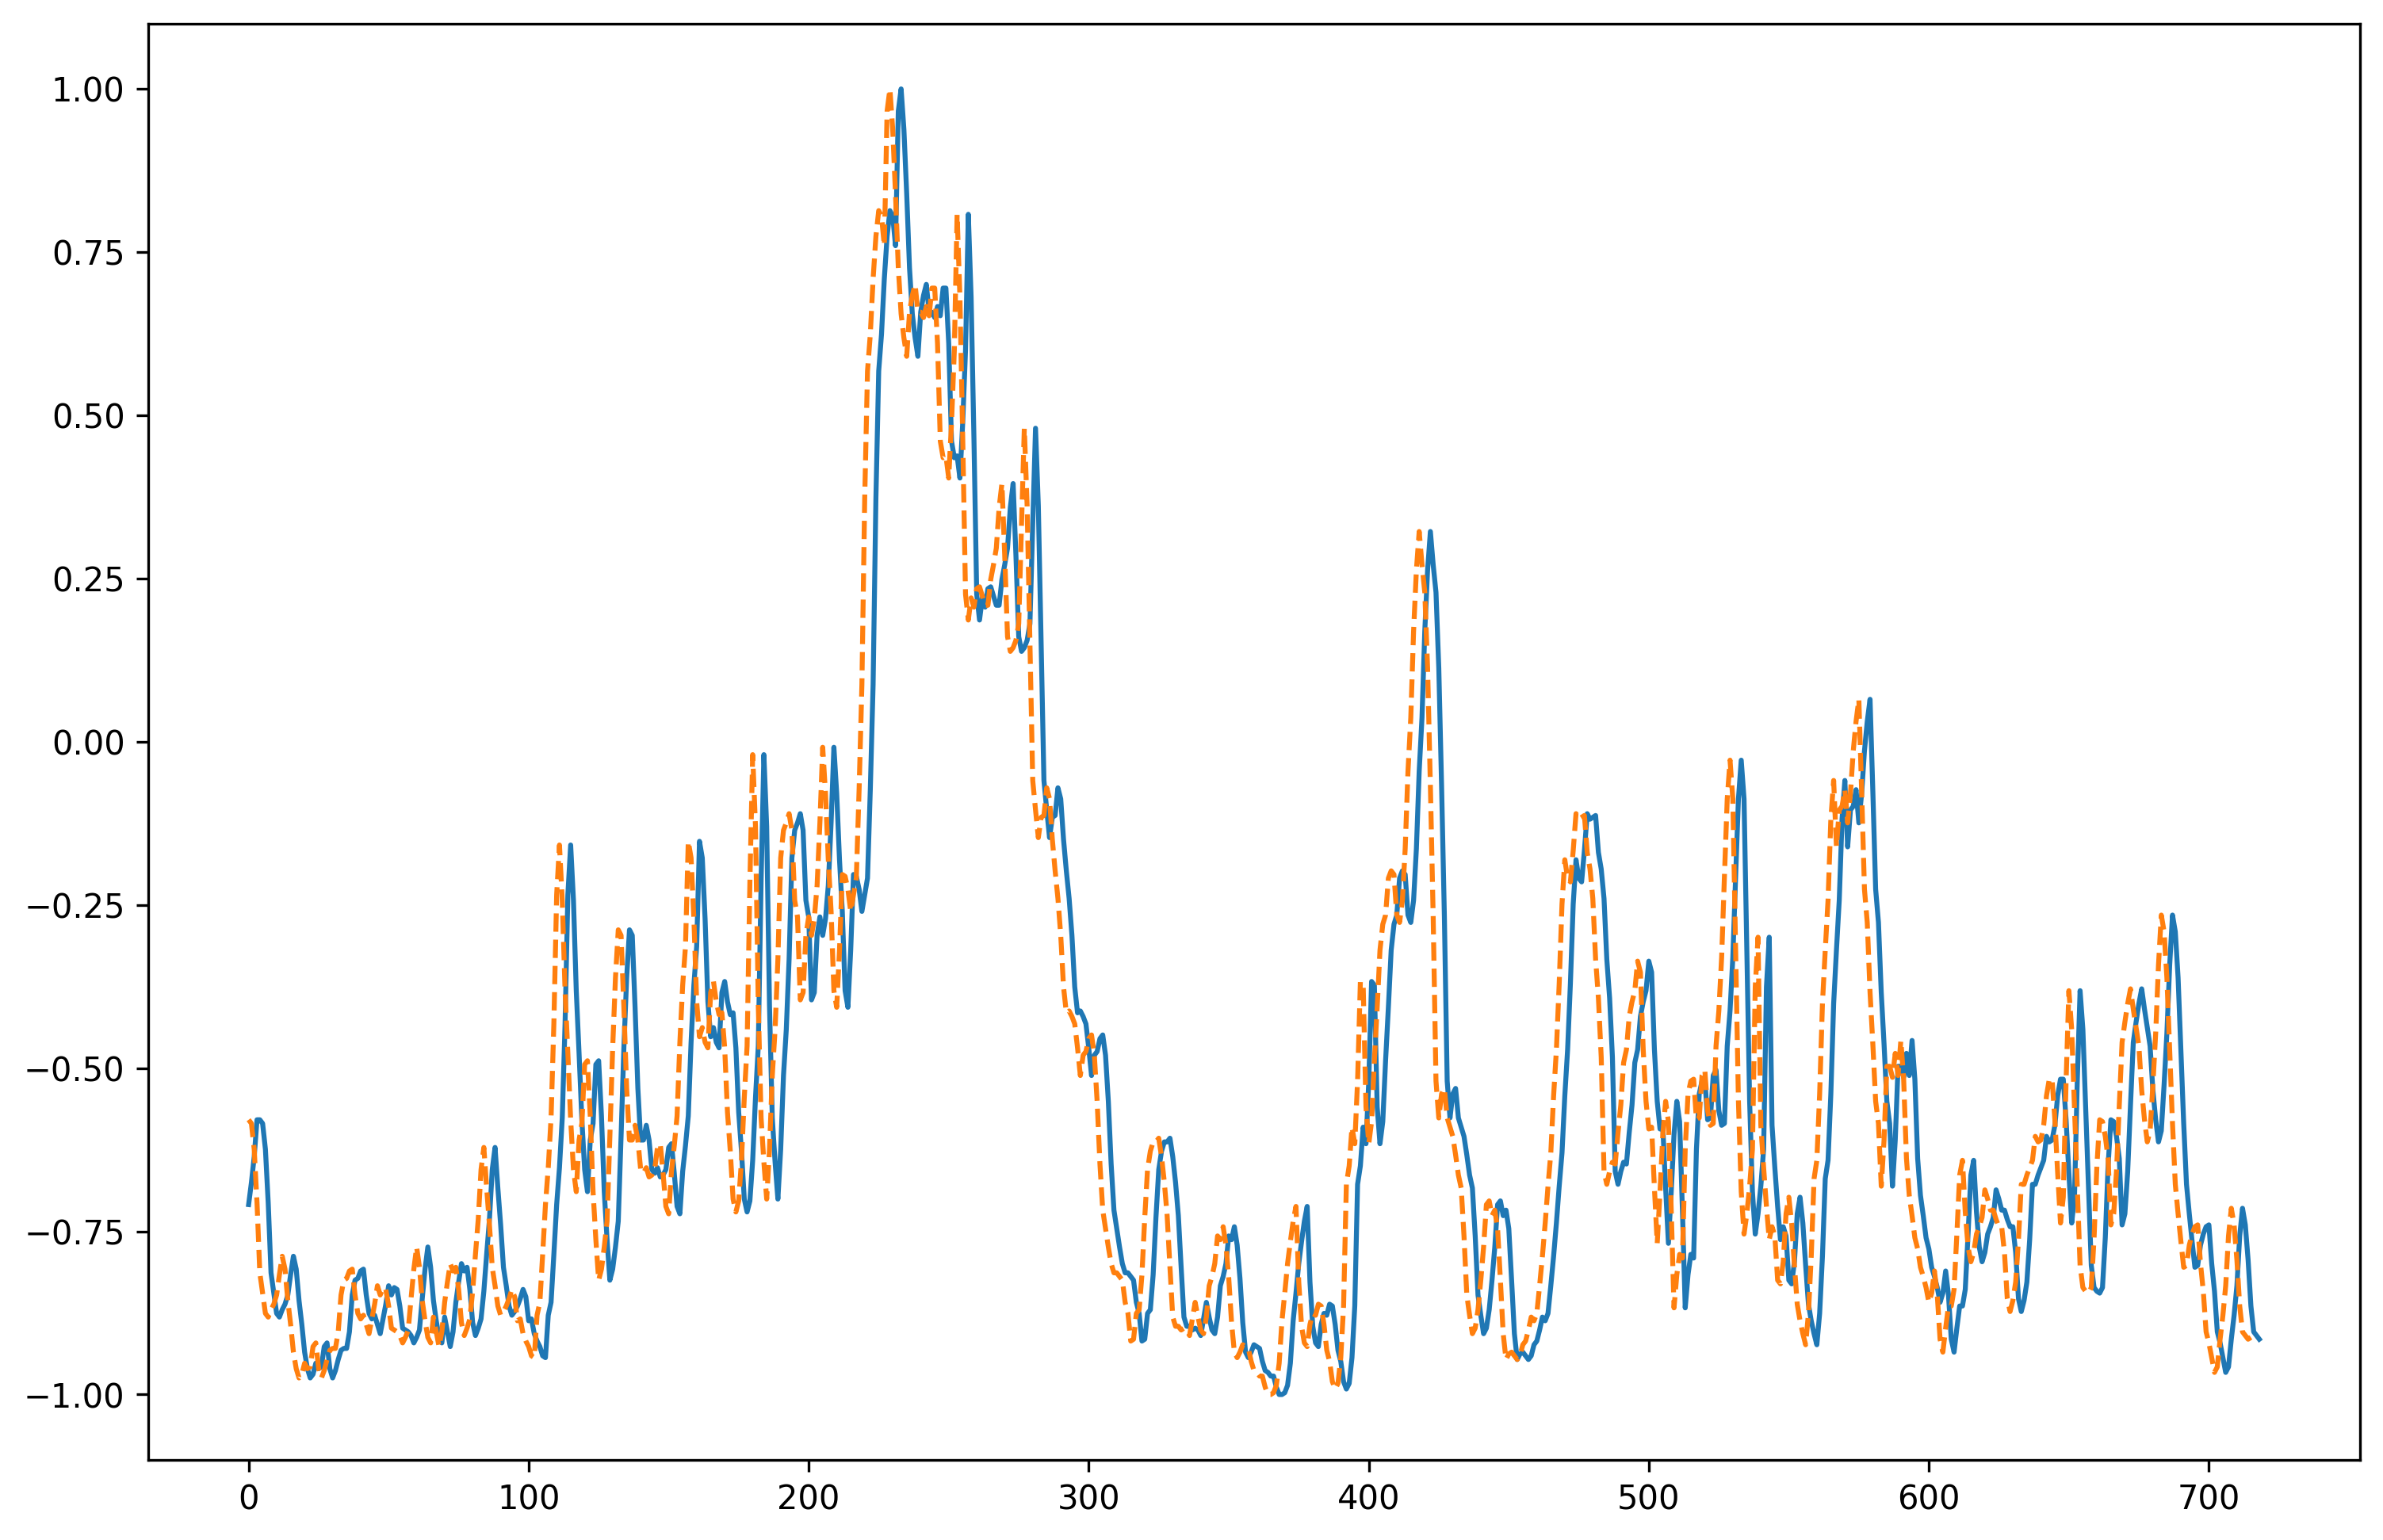

In [14]:

# Imposta la dimensione della figura e la qualità (dpi)
plt.figure(figsize=(12, 8), dpi=300)  # Aumenta la dimensione e la risoluzione

#simulation_res = read_and_display_pickle_file(path)['simulation_result']
#fai lo stack di train e test
stack = np.concatenate((train, test[4:]))
naive = naive_predictor(stack)
ground_truth = read_and_display_pickle_file(path)['ground_truth']
plt.plot(naive, '-')
plt.plot(ground_truth.detach().numpy(), '--')


=== Content of VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_2_QuLAYERS_old/VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_2_QuLAYERS_NO_2_Epoch_100_SIMULATION_RESULT.txt ===
{'simulation_result': array([[-5.23542249e-01],
       [-5.39215264e-01],
       [-5.49039638e-01],
       [-5.95354865e-01],
       [-6.78971538e-01],
       [-7.75793515e-01],
       [-7.93849562e-01],
       [-8.18870414e-01],
       [-8.21970277e-01],
       [-8.10367767e-01],
       [-8.02066000e-01],
       [-7.88479593e-01],
       [-7.57738109e-01],
       [-7.30365437e-01],
       [-7.53732741e-01],
       [-8.00919865e-01],
       [-8.33741838e-01],
       [-8.70761504e-01],
       [-8.92700689e-01],
       [-9.04988160e-01],
       [-9.00447801e-01],
       [-8.85439177e-01],
       [-8.92142672e-01],
       [-8.90050288e-01],
       [-8.62444766e-01],
       [-8.56679195e-01],
       [-8.91433534e-01],
       [-9.04797550e-01],
       [-8.95699432e-01],
       [-8.80284978e-01],
     

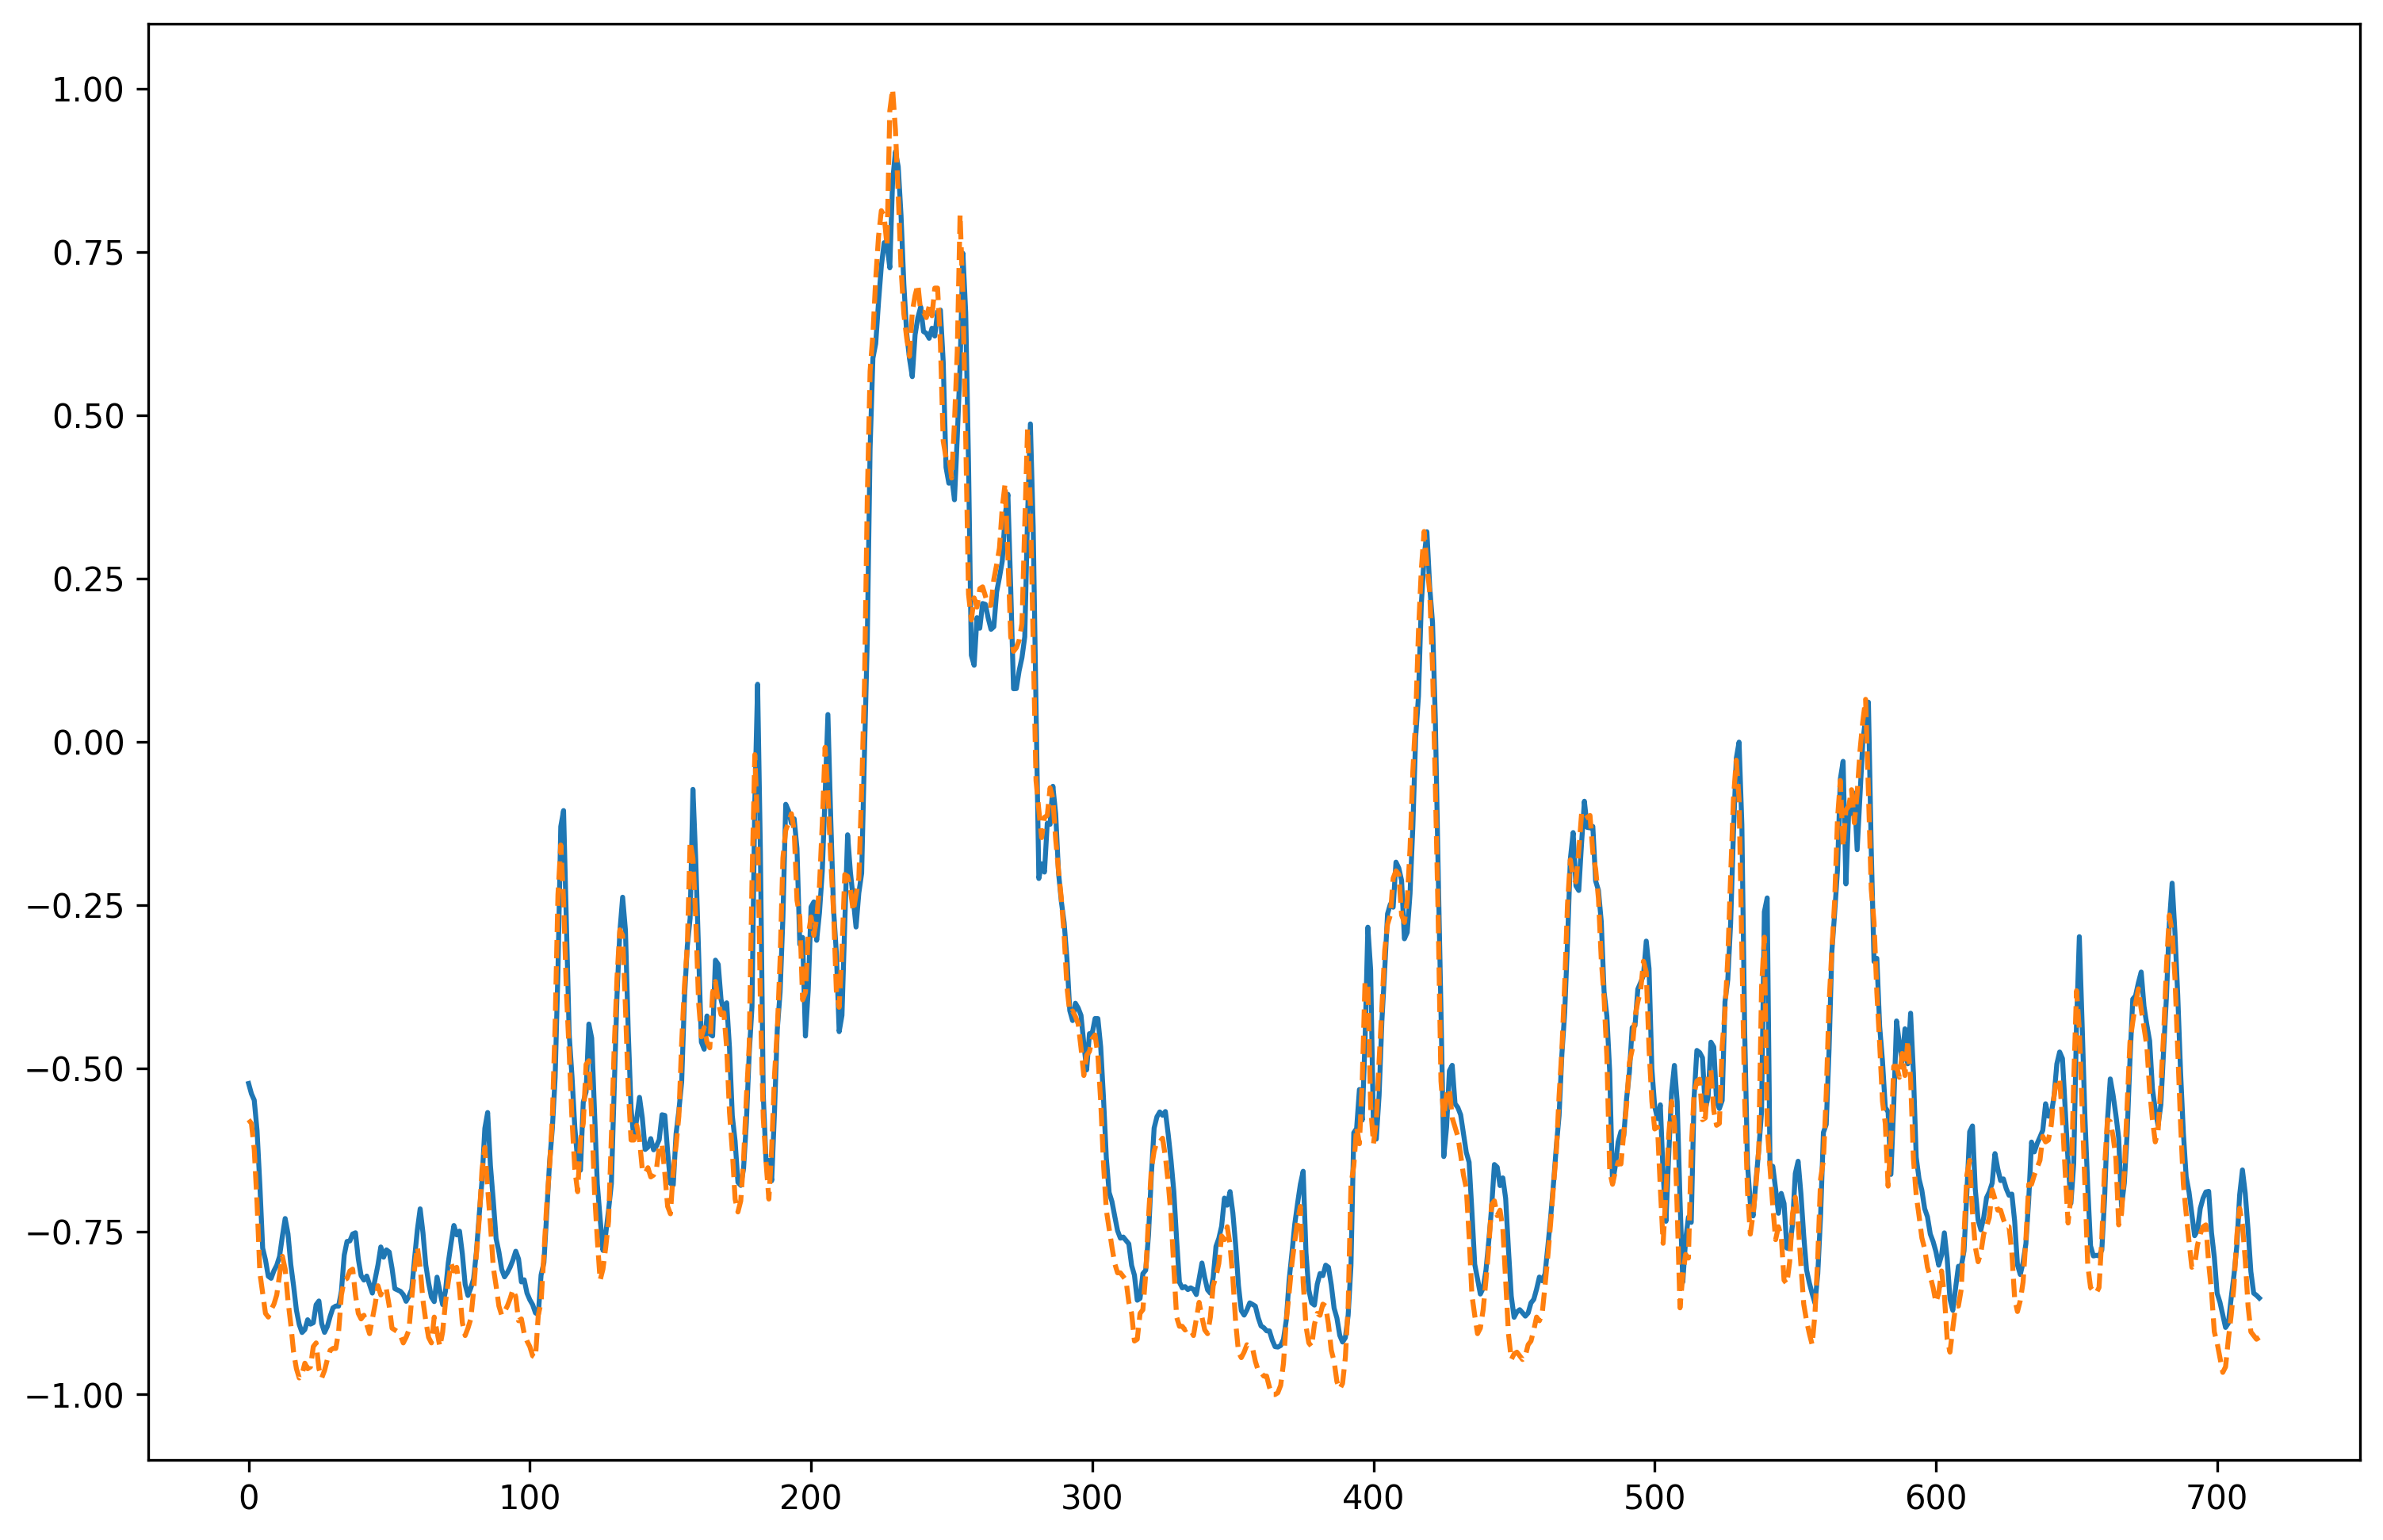

In [16]:

path = 'VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_2_QuLAYERS_old/VQ_LSTM_BASE_CLASS_TS_MODEL__DATALOADER_BESSEL_4_QUBIT_2_QuLAYERS_NO_2_Epoch_100_SIMULATION_RESULT.txt'

# Imposta la dimensione della figura e la qualità (dpi)
plt.figure(figsize=(12, 8), dpi=300)  # Aumenta la dimensione e la risoluzione

#simulation_res = read_and_display_pickle_file(path)['simulation_result']
#fai lo stack di train e test
stack = np.concatenate((train, test[4:]))
ground_truth = read_and_display_pickle_file(path)['ground_truth']
results = read_and_display_pickle_file(path)['simulation_result']
plt.plot(results, '-')
plt.plot(ground_truth.detach().numpy(), '--')